#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Sentiment Analysis`

#### Group 05:
- Karolina Rączkowska 20241250
- Michał Wójcik 20241255
- Hubert Kołomański 20241253
- Marek Rewoliński 20241452
- Christian Deluca 20241264  

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id="toc"> 
The correct way to create markdown links that connect to other parts of the notebook involves removing the extra anchor tags and slightly modifying the format. Here's the proper markdown structure:

- [1. Data preparation](#P1)
- [2. Sentiment analysis with RoBERTa](#P2)
    - [2.1. Data modelling](#P2.1)
    - [2.2. Model evaluation with labels](#P2.2)
    - [2.3. Model evaluation with probabilities](#P2.3)
- [3. Sentiment analysis with Vader](#P3)
    - [3.1. Data modelling](#P3.1)
    - [3.2. Model evaluation](#P3.2)
- [4. Model comparison](#P4)
- [5. Emotion detection](#P5)
</a>

In [2]:
# Enable autoreload for automatic module reloading
%load_ext autoreload
%autoreload 2

# Core libraries
import pandas as pd
import numpy as np
import re
import csv
import urllib.request
from tqdm import tqdm

# Transformers for NLP tasks
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline

# Preprocessing utilities
import Preprocessing
from nltk.tokenize import PunktSentenceTokenizer
# Uncomment the line below to download the Punkt tokenizer if needed
# nltk.download('punkt_tab')

# NLTK for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Uncomment the line below to download the VADER lexicon if needed
# nltk.download('vader_lexicon')

# TextBlob for sentiment analysis
from textblob import TextBlob
# Uncomment the line below to install TextBlob if needed
# %pip install textblob

# Metrics for regression and classification
from scipy.stats import pearsonr
from scipy.special import softmax
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    mean_squared_error, 
    mean_absolute_percentage_error
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Uncomment the line below to install WordCloud if needed
# %pip install wordcloud


[1. Data preparation](#P1)

In [3]:
restaurants_raw = pd.read_csv(r"data_hyderabad/105_restaurants.csv")
reviews_raw = pd.read_csv(r"data_hyderabad/10k_reviews.csv")

In [4]:
restaurants_raw.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [5]:
reviews_data = reviews_raw[reviews_raw["Rating"].notna() & reviews_raw["Review"].notna()]
reviews_data.isna().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [6]:
reviews_data.drop(reviews_data[reviews_data['Rating']=='Like'].index, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12776\1159352641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data.drop(reviews_data[reviews_data['Rating']=='Like'].index, inplace=True)


In [13]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Restaurant         9954 non-null   object
 1   Reviewer           9954 non-null   object
 2   Review             9954 non-null   object
 3   Rating             9954 non-null   object
 4   Metadata           9954 non-null   object
 5   Time               9954 non-null   object
 6   Pictures           9954 non-null   int64 
 7   Extracted_Ratings  9954 non-null   object
dtypes: int64(1), object(7)
memory usage: 699.9+ KB


In [14]:
reviews_data['Review'] = reviews_data['Review'].astype(str)
reviews_data['Rating'] = reviews_data['Rating'].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_17008\39945892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Review'] = reviews_data['Review'].astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_17008\39945892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Rating'] = reviews_data['Rating'].astype(float)


In [16]:
reviews_data['Preprocessed_Review'] = reviews_data['Review'].apply(lambda x: Preprocessing.main_pipeline(
    x,no_hashtags=False,
    no_newlines=True,
    no_urls=True,
    no_punctuation=False,
    print_output=False, 
    lowercase=False, 
    lemmatized=False,
    stemmed=False))

C:\Users\User\AppData\Local\Temp\ipykernel_17008\300220615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['Preprocessed_Review'] = reviews_data['Review'].apply(lambda x: Preprocessing.main_pipeline(


In [18]:
reviews_preproc = reviews_data.copy()

[2. Sentiment analysis with RoBERTa](#P2)

[2.1. Data modelling](#P2.1)

In [20]:
model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model)
sentiment_tokenizer = AutoTokenizer.from_pretrained(model)
#optimus_primer = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

c:\Users\User\anaconda3\envs\text-mining1\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\User\anaconda3\envs\text-mining1\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

In [21]:
sentiment_task = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer, max_length=510,truncation=True)

In [22]:
reviews_sentiment_label = reviews_preproc.copy()

In [23]:
from tqdm import tqdm

sentiments = []
for review in tqdm(reviews_sentiment_label['Preprocessed_Review']):
    try:
        sentiment = sentiment_task(review, max_length=510, truncation=True)
        sentiments.append(sentiment[0])
    except RuntimeError as e:
        print(f"RuntimeError for review: {review}\nError: {e}")
        sentiments.append({'label': 'error', 'score': 0.0})

reviews_sentiment_label['Sentiment_Label'] = [sentiment['label'] for sentiment in sentiments]
reviews_sentiment_label['Sentiment_Score'] = [sentiment['score'] for sentiment in sentiments]

Processing reviews:   0%|          | 36/9954 [00:04<19:20,  8.55it/s]


KeyboardInterrupt: 

[2.2. Model evaluation with labels](#P2.2)

In [34]:
reviews_sentiment_label = pd.read_csv('reviews_sentiment_label.csv')

In [35]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   object 
 9   Sentiment_Score      9954 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 777.8+ KB


In [36]:
reviews_sentiment_label['Sentiment_Label'] = reviews_sentiment_label['Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [37]:
reviews_sentiment_label.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803


In [38]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [39]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   int64  
 9   Sentiment_Score      9954 non-null   float64
 10  Rating_label         9954 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 855.5+ KB


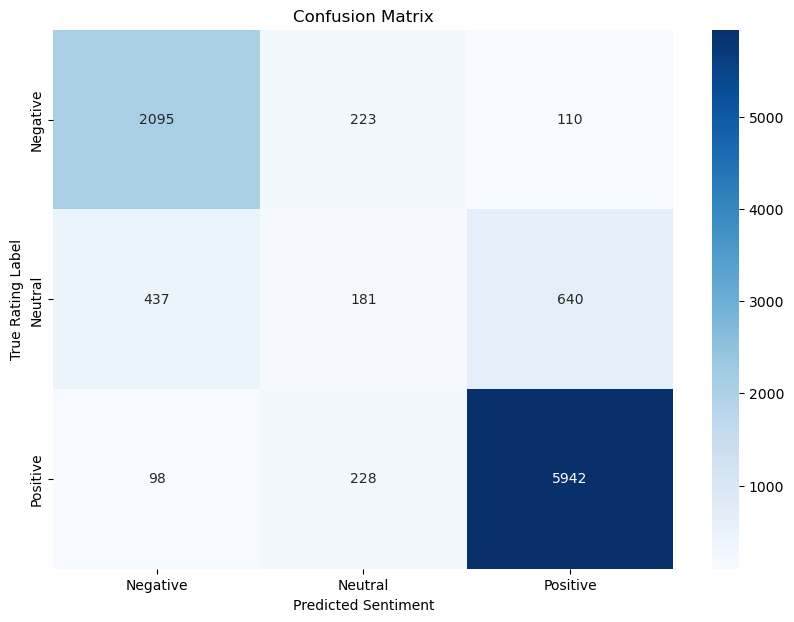

In [40]:
# Create the confusion matrix
conf_matrix = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Sentiment_Label'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
true_labels = reviews_sentiment_label['Rating_label']
predicted_labels = reviews_sentiment_label['Sentiment_Label']

report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83      2428
     Neutral       0.29      0.14      0.19      1258
    Positive       0.89      0.95      0.92      6268

    accuracy                           0.83      9954
   macro avg       0.66      0.65      0.65      9954
weighted avg       0.79      0.83      0.80      9954



In [42]:
reviews_sentiment_label.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score,Rating_label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,2
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,2
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,2
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,2
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,2


In [43]:
reviews_sentiment_label['Preprocessed_review2'] = reviews_sentiment_label['Review'].apply(lambda content:\
    Preprocessing.main_pipeline(str(content), 
                                no_hashtags=True,
                                no_newlines=True, 
                                no_urls=True, 
                                no_punctuation=True, 
                                lowercase=True, 
                                lemmatized=True, 
                                stemmed=False, 
                                print_output=False,
                                no_stopwords=True,
                                ))
    

In [44]:
reviews_sentiment_label.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Sentiment_Label,Sentiment_Score,Rating_label,Preprocessed_review2
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,2,ambience good food quite good saturday lunch c...
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,2,ambience good pleasant even service prompt foo...
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,2,must try great food great ambience thnx servic...
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,2,soumen da arun great guy behavior sincerety go...
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,2,food order kodi drumstick basket mutton biryan...


In [45]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")

In [46]:
positive_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 2]
neutral_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 1]
negative_reviews = reviews_sentiment_label[reviews_sentiment_label['Sentiment_Label'] == 0]

In [47]:
reviews_all = [positive_reviews, neutral_reviews, negative_reviews]

In [48]:
bow_matrices = []
bow_features_list = []

for reviews in reviews_all:
    bow_matrix = bow_vectorizer.fit_transform(reviews['Preprocessed_review2']).toarray()
    reviews['bow_matrix'] = bow_matrix.tolist()
    bow_features = bow_vectorizer.get_feature_names_out()
    
    bow_matrices.append(bow_matrix)
    bow_features_list.append(bow_features)

C:\Users\User\AppData\Local\Temp\ipykernel_30456\3373098347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['bow_matrix'] = bow_matrix.tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_30456\3373098347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['bow_matrix'] = bow_matrix.tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_30456\3373098347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [49]:
def word_freq(bow_matrices, bow_features_list, idx,):
    word_counts = np.sum(bow_matrices[idx], axis=0)
    word_freq = pd.DataFrame({'words': bow_features_list[idx], 'frequency': word_counts})
    word_freq = word_freq.sort_values(by='frequency', ascending=False)
    return dict(zip(bow_features_list,word_counts))

In [50]:
def plot_term_frequency(df,nr_terms):
    
    plt.figure(figsize=(10, 8))
    sns_plot = sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    plt.title(f"Top {nr_terms} Words")
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()


In [51]:
# Function to calculate word frequency
def word_freq(bow_matrices, bow_features_list, idx):
    word_counts = np.sum(bow_matrices[idx], axis=0)
    word_freq = pd.DataFrame({'words': bow_features_list[idx], 'frequency': word_counts})
    word_freq = word_freq.sort_values(by='frequency', ascending=False)
    return word_freq

# Function to plot term frequency
def plot_term_frequency(df, nr_terms, type):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    plt.title(f"Top {nr_terms} words in {type} reviews")
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Function to generate and display a word cloud
def plot_wordcloud(word_freq_df, type):
    word_freq_dict = dict(zip(word_freq_df['words'], word_freq_df['frequency']))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word cloud of {type} reviews")
    plt.show()


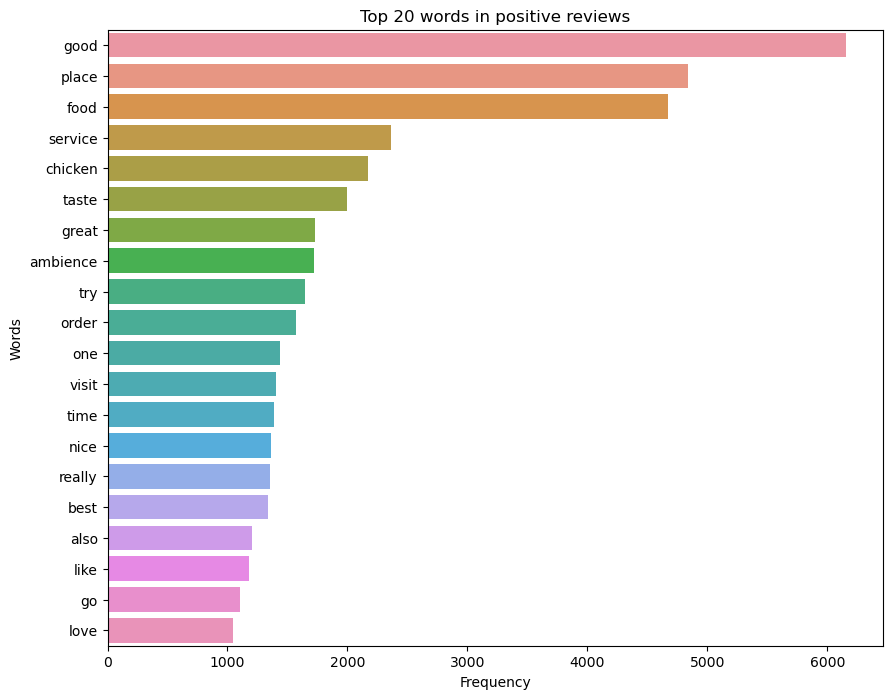

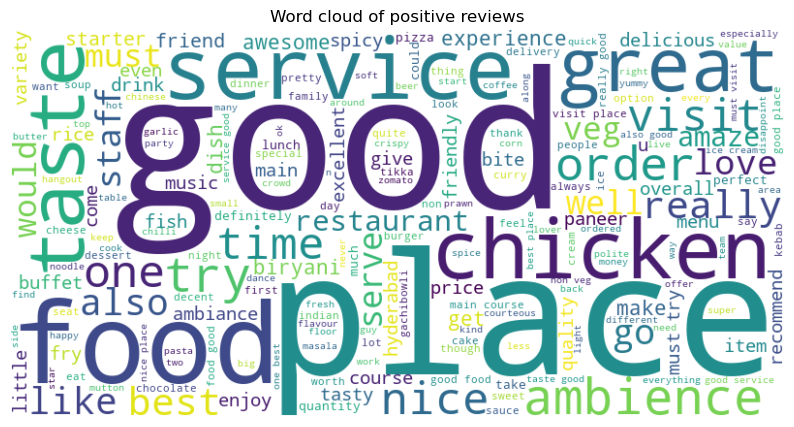

In [52]:
# Positive reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 0)
plot_term_frequency(word_freq_df, 20, 'positive')
plot_wordcloud(word_freq_df, 'positive')

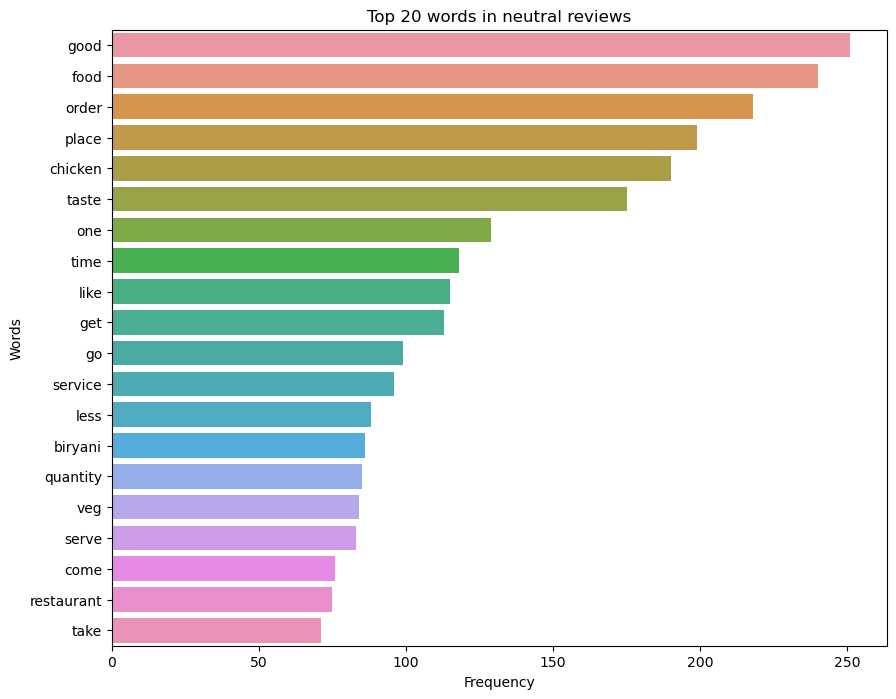

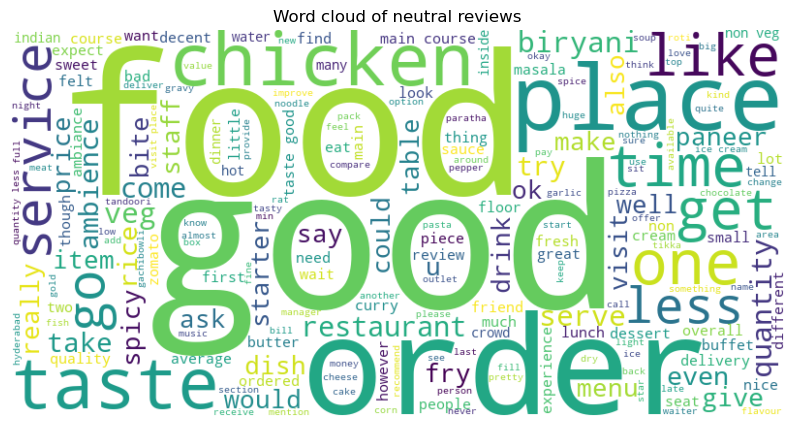

In [53]:
# Neutral reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 1)
plot_term_frequency(word_freq_df, 20, 'neutral')
plot_wordcloud(word_freq_df, 'neutral')

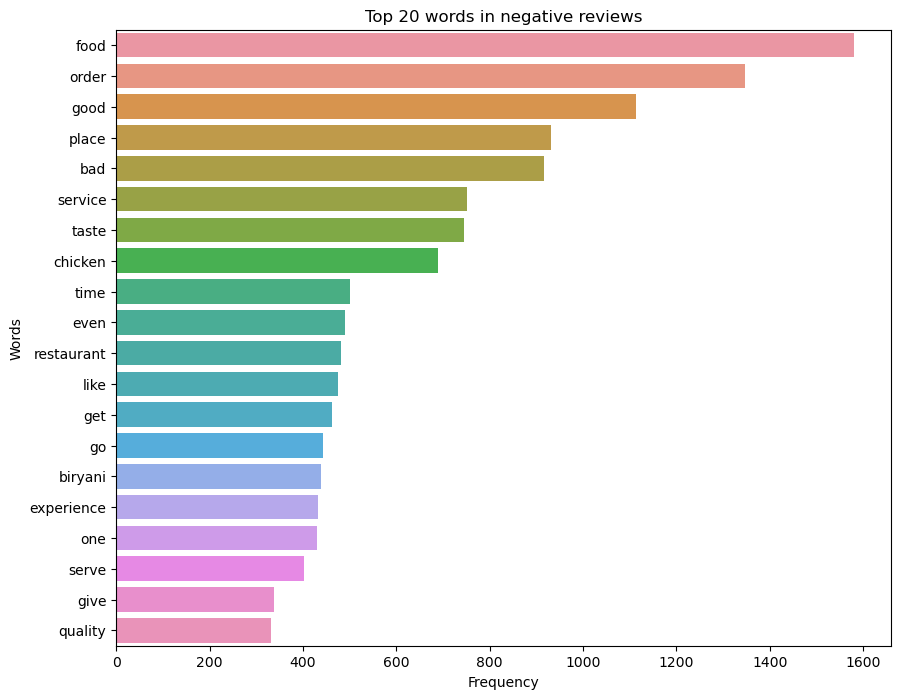

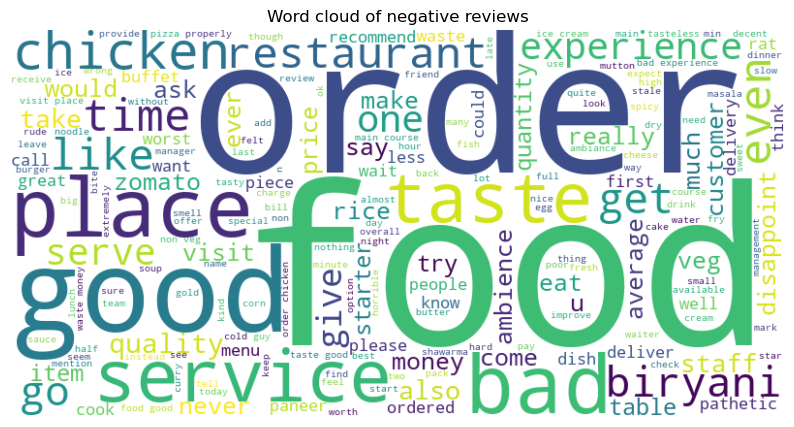

In [54]:
# Negative reviews - 20 terms
word_freq_df = word_freq(bow_matrices, bow_features_list, 2)
plot_term_frequency(word_freq_df, 20, 'negative')
plot_wordcloud(word_freq_df, 'negative')

[2.3. Model evaluation with probabilities](#P2.3.)

In [150]:
reviews_sentiment_polariy = reviews_preproc.copy()

In [ ]:
def optimus_sentimenter(review):
    encoded_input = sentiment_tokenizer(review, return_tensors='pt', truncation=True, max_length=510)
    sent = sentiment_model(**encoded_input)
    sent_scores = softmax(sent[0][0].detach().numpy())
    sent_scores_dict = {
    'negative': sent_scores[0],
    'neutral': sent_scores[1],
    'positive': sent_scores[2]}
    return sent_scores_dict

In [ ]:
negative_scores = []
neutral_scores = []
positive_scores = []

for review in reviews_sentiment_polariy['Preprocessed_Review']:
    try:
        scores = optimus_sentimenter(review)
        negative_scores.append(scores['negative'])
        neutral_scores.append(scores['neutral'])
        positive_scores.append(scores['positive'])
    except RuntimeError as e:
        print(f"RuntimeError for review: {review}\nError: {e}")
        negative_scores.append(None)
        neutral_scores.append(None)
        positive_scores.append(None)

reviews_sentiment_polariy['negative'] = negative_scores
reviews_sentiment_polariy['neutral'] = neutral_scores
reviews_sentiment_polariy['positive'] = positive_scores

In [153]:
#This model outputs 3 labels and their scores: negative, netural and positive. We then calculate polarity score.
#Polarity score = (negatives - positives) / (negatives + positives)
reviews_sentiment_polariy = pd.read_csv('reviews_sentiment_polarity.csv')

In [154]:
reviews_sentiment_polariy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   negative             9954 non-null   float64
 9   neutral              9954 non-null   float64
 10  positive             9954 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 855.5+ KB


In [157]:
reviews_sentiment_polariy['Polarity'] = (reviews_sentiment_polariy['positive'] - reviews_sentiment_polariy['negative'])/ \
(reviews_sentiment_polariy['positive'] + reviews_sentiment_polariy['negative'])

In [ ]:
reviews_sentiment_polariy['Rating_Scaled'] = ((reviews_sentiment_polariy['Rating'].astype(float) - 1) / 2) - 1

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,negative,neutral,positive,Polarity,Rating_Scaled
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",0.004108,0.020891,0.975001,0.991608,1.00
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,0.005603,0.015750,0.978647,0.988615,1.00
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,0.003418,0.008538,0.988044,0.993104,1.00
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,0.006249,0.021480,0.972271,0.987228,1.00
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,0.003587,0.015610,0.980803,0.992711,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,0.018283,0.111681,0.870036,0.958837,0.00
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,0.004934,0.011973,0.983094,0.990013,0.75
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0.531457,0.389869,0.078674,-0.742109,-0.75
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,0.003832,0.013546,0.982623,0.992231,0.50


In [223]:
corr_spearman = reviews_sentiment_polariy[['Rating_Scaled', 'Polarity']].corr(method='spearman')
corr_pearson = reviews_sentiment_polariy[['Rating_Scaled', 'Polarity']].corr(method='pearson')

print(f"Spearman correlation: {round(corr_spearman.iloc[0][1],2)}")
print(f"Pearson correlation: {round(corr_pearson.iloc[0][1],2)}")

Spearman correlation: 0.73
Pearson correlation: 0.84


In [162]:
reviews_sentiment_polariy.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,negative,neutral,positive,Polarity,Rating_Scaled
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",0.004108,0.020891,0.975001,0.991608,1.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,0.005603,0.015750,0.978647,0.988615,1.0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,0.003418,0.008538,0.988044,0.993104,1.0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,0.006249,0.021480,0.972271,0.987228,1.0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,0.003587,0.015610,0.980803,0.992711,1.0


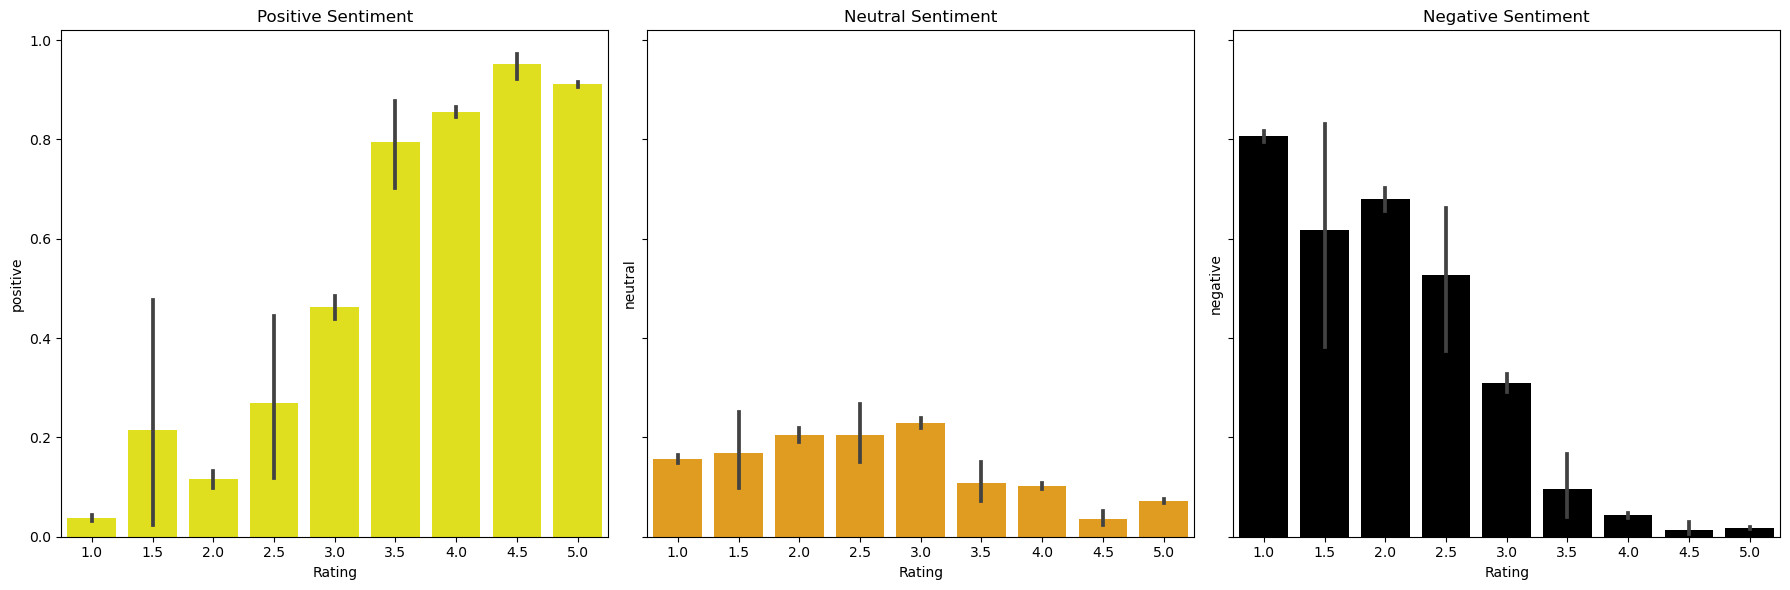

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='positive',color='yellow', ax=axes[0])
axes[0].set_title('Positive Sentiment')

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='neutral', color='orange', ax=axes[1])
axes[1].set_title('Neutral Sentiment')

sns.barplot(data=reviews_sentiment_polariy, x='Rating', y='negative', color='black', label='negative', ax=axes[2])
axes[2].set_title('Negative Sentiment')

plt.tight_layout()
plt.show()

In [ ]:
# Reviews that were rated as negative (rating 1 , 1.5, 2) but model classified as positive
reviews_sent_pos = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] <2.5) & (reviews_sentiment_polariy['Polarity'] > 0.5)].sort_values(by='Polarity', ascending=False)
reviews_sent_pos.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1.0,40.0,0.843234,0.129840,0.503860,0.746833,0.878669,0.954903,0.988703
1.5,2.0,0.966347,0.018141,0.953519,0.959933,0.966347,0.972761,0.979175
2.0,72.0,0.839747,0.148170,0.507940,0.754081,0.908628,0.968074,0.990361


In [207]:
# Reviews that were rated as neutral (rating 2.5, 3 , 3.5) but model classified as negative
reviews_sent_nue = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=2.5) & (reviews_sentiment_polariy['Rating'] <4)
                                             & (reviews_sentiment_polariy['Polarity'] < -0.25)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_nue.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
2.5,12.0,-0.872876,0.124472,-0.977427,-0.965497,-0.940307,-0.744798,-0.635713
3.0,463.0,-0.825768,0.189478,-0.989099,-0.968213,-0.916485,-0.737101,-0.253424
3.5,4.0,-0.870590,0.125972,-0.979141,-0.964993,-0.897753,-0.803350,-0.707712


In [ ]:
# Reviews that were rated as neutral (rating 2.5, 3 , 3.5) but model classified as positive
reviews_sent_nue2 = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=2.5) & (reviews_sentiment_polariy['Rating'] <4)
                                             & (reviews_sentiment_polariy['Polarity'] > 0.5)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_nue2.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
2.5,4.0,0.975864,0.013757,0.956067,0.971749,0.981006,0.985122,0.985376
3.0,602.0,0.910393,0.114116,0.500109,0.877738,0.962855,0.985038,0.996161
3.5,40.0,0.958159,0.098455,0.522065,0.972163,0.988669,0.992931,0.994876


In [ ]:
#Reviews that were rated as positive (4, 4.5 or 5), but model classified as negatve
reviews_sent_neg = reviews_sentiment_polariy[(reviews_sentiment_polariy['Rating'] >=4) & \
                                             (reviews_sentiment_polariy['Polarity'] < -0.25)]\
                                                 .sort_values(by='Polarity', ascending=False)
reviews_sent_neg.groupby('Rating')['Polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
4.0,107.0,-0.737218,0.204333,-0.987786,-0.918556,-0.803038,-0.580396,-0.262694
4.5,1.0,-0.796625,NaN,-0.796625,-0.796625,-0.796625,-0.796625,-0.796625
5.0,30.0,-0.712925,0.210267,-0.981282,-0.906770,-0.736401,-0.560483,-0.282108


[3. Sentiment analysis with Vader](#P2)

[3.1. Data modelling](#P3.1.)

In [ ]:
vader = SentimentIntensityAnalyzer()

In [ ]:
#example
print(reviews_sentiment_label['Preprocessed_Review'].iloc[0])
print(vader.polarity_scores(reviews_sentiment_label['Review'].iloc[0]))

In [ ]:
reviews_compound_list = []
for review in reviews_sentiment_label['Review']:
    review_polarity = vader.polarity_scores(review)
    reviews_compound_list.append(review_polarity["compound"])

In [ ]:
reviews_sentiment_label["VADER_Sentiment_Score"] = reviews_compound_list

In [ ]:
reviews_sentiment_label["VADER_Sentiment_Label"] = list(
    map(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral",
        reviews_sentiment_label["VADER_Sentiment_Score"]))

In [ ]:
reviews_sentiment_label['VADER_Sentiment_Label'] = reviews_sentiment_label['VADER_Sentiment_Label'].map(
    {'negative': 0, 'neutral': 1, 'positive': 2})

In [ ]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(
    lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [ ]:
reviews_sentiment_label[["Rating_label", "Transformer_Sentiment_Label", "VADER_Sentiment_Label"]]

In [ ]:
# confusion matrix VADER
conf_matrix2 = confusion_matrix(reviews_sentiment_label['Rating_label'],
                                reviews_sentiment_label['VADER_Sentiment_Label'])
# conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'],
#                                 reviews_sentiment_label['Transformer_Sentiment_Label'])

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for VADER')
# plt.savefig("cf-vader.jpg", format='jpg')
plt.show()


[4. Model comparison](#P5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for side-by-side comparison

# VADER Confusion Matrix
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('True Rating Label')
axes[0].set_title('Confusion Matrix for VADER')

# Transformer-based Confusion Matrix
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('True Rating Label')
axes[1].set_title('Confusion Matrix for Transformer-based SA')

# Adjust layout for readability
plt.tight_layout()
plt.savefig("cf-for-both.jpg")
plt.show()

[5. Emotion detection](#P5)

In [224]:
model_emotion = f"cardiffnlp/twitter-roberta-base-emotion"
emotion_model = AutoModelForSequenceClassification.from_pretrained(model_emotion)
emotion_tokenizer = AutoTokenizer.from_pretrained(model_emotion)
#optimus_primer = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

c:\Users\User\anaconda3\envs\text-mining1\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\User\anaconda3\envs\text-mining1\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

In [227]:
# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
labels

['anger', 'joy', 'optimism', 'sadness']

In [256]:
reviews_emotions = reviews_preproc.copy()

In [258]:
joy_scores = []
optimism_scores = []
anger_scores = []
sadness_scores = []

for review in tqdm(reviews_emotions['Preprocessed_Review']):
    encoded_input = emotion_tokenizer(review, return_tensors='pt', truncation=True, max_length=510)
    output = emotion_model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    
    joy_scores.append(scores[labels.index('joy')])
    optimism_scores.append(scores[labels.index('optimism')])
    anger_scores.append(scores[labels.index('anger')])
    sadness_scores.append(scores[labels.index('sadness')])

# Create new columns in the DataFrame
reviews_emotions['joy'] = joy_scores
reviews_emotions['optimism'] = optimism_scores
reviews_emotions['anger'] = anger_scores
reviews_emotions['sadness'] = sadness_scores


  1%|          | 60/9954 [00:06<18:59,  8.68it/s]


KeyboardInterrupt: 

In [3]:
reviews_emotions = pd.read_csv('reviews_emotions.csv')

In [4]:
reviews_emotions=reviews_emotions[['Rating', 'Preprocessed_Review', 'joy', 'optimism', 'anger', 'sadness']]

C:\Users\User\AppData\Local\Temp\ipykernel_30456\1426788419.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_emotions = reviews_emotions.groupby('Rating').mean().reset_index()


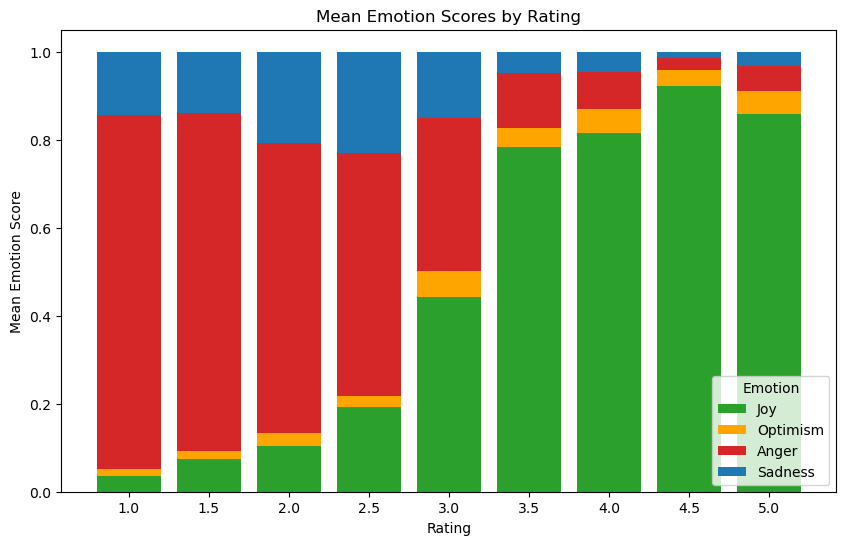

In [6]:
mean_emotions = reviews_emotions.groupby('Rating').mean().reset_index()

ratings = mean_emotions['Rating']
joy = mean_emotions['joy']
optimism = mean_emotions['optimism']
anger = mean_emotions['anger']
sadness = mean_emotions['sadness']

x = np.arange(len(ratings))

plt.figure(figsize=(10, 6))
plt.bar(x, joy, label='Joy', color='#2ca02c')
plt.bar(x, optimism, bottom=joy, label='Optimism', color='#ffa500')
plt.bar(x, anger, bottom=joy + optimism, label='Anger', color='#d62728')
plt.bar(x, sadness, bottom=joy + optimism + anger, label='Sadness', color='#1f77b4')

plt.xticks(x, ratings)
plt.xlabel('Rating')
plt.ylabel('Mean Emotion Score')
plt.title('Mean Emotion Scores by Rating')
plt.legend(title='Emotion')

plt.show()

In [ ]:
reviews_emotions_neg = reviews_emotions[(reviews_emotions['Rating'] < 2.5)]
mean_emotions_neg = reviews_emotions_neg.groupby('Rating').mean().reset_index()
mean_emotions_neg

In [275]:
# Reviews that were rated as neutral
reviews_emotions_neu = reviews_emotions[(reviews_emotions['Rating'] >2) & (reviews_emotions['Rating'] <4)]
reviews_emotions_neu.groupby('Rating').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_8340\3755010546.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews_emotions_neu.groupby('Rating').mean()


,joy,optimism,anger,sadness
Rating,,,,
2.5,0.191433,0.027169,0.552293,0.229105
3.0,0.441682,0.061010,0.347203,0.150105
3.5,0.783951,0.043434,0.125244,0.047370


In [276]:
# Reviews that were rated as positive
reviews_emotions_pos = reviews_emotions[(reviews_emotions['Rating']>3.5)]
reviews_emotions_pos.groupby('Rating').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_8340\4122995346.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews_emotions_pos.groupby('Rating').mean()


,joy,optimism,anger,sadness
Rating,,,,
4.0,0.816333,0.054272,0.083645,0.045749
4.5,0.921670,0.037501,0.025861,0.014968
5.0,0.858456,0.052262,0.056971,0.032311
